### Set up Data and Import Libraries

In [146]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [95]:
#Define df as our Dataset and drop not needed columns
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.99 (PC1 - PC46)
X = df[df.columns[57:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]

In [96]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

### Visualize and exploratory data analysis Data 

In [5]:
df_v = pd.read_csv("data_clean_WITHOUT_dummies.csv") #Load the Dataset without Dummie variables for better visualization
df_v = df_v.drop(labels=range(0,144), axis=0) #Drop the first 144 rows to start with a monday and have better Visualization. The 144 Rows dont matter since we have over 15000
df_v = df_v.set_index('date') #Set the date as the index 

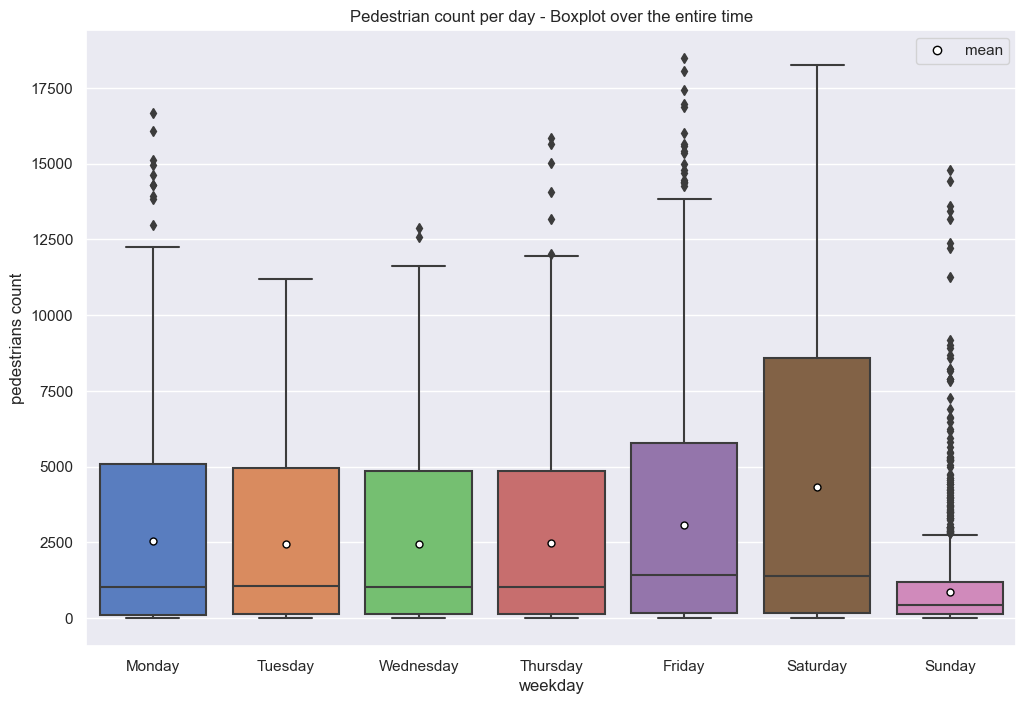

In [6]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", showmeans=True,  
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per day - Boxplot over the entire time')
axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

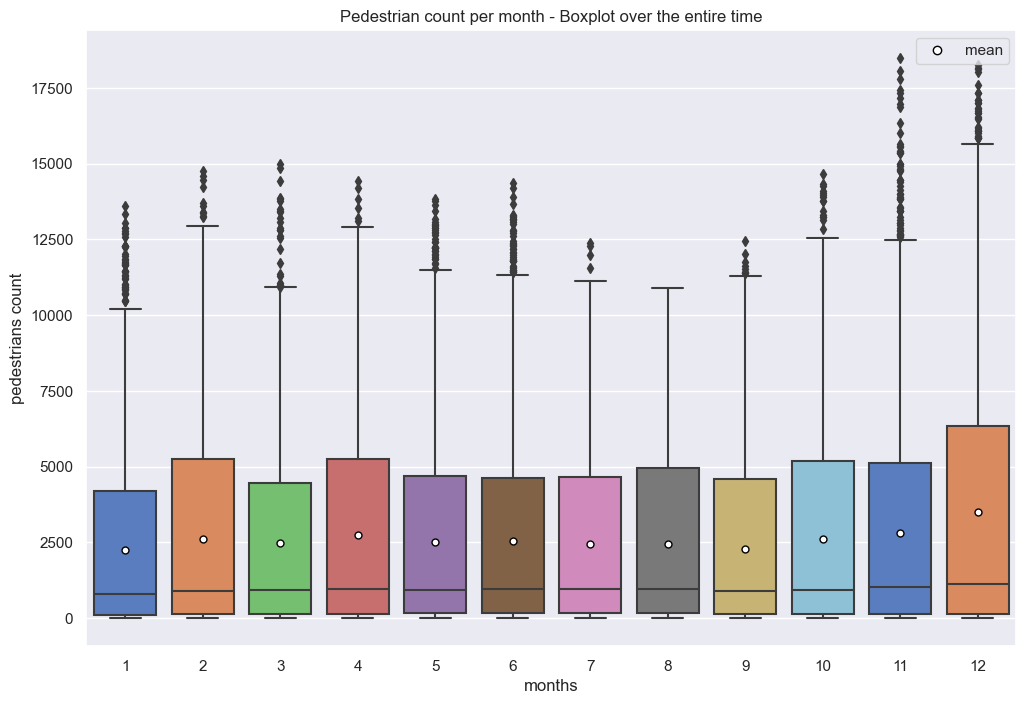

In [7]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, y="pedestrians count", x="months", palette="muted", showmeans=True, 
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per month - Boxplot over the entire time')

axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

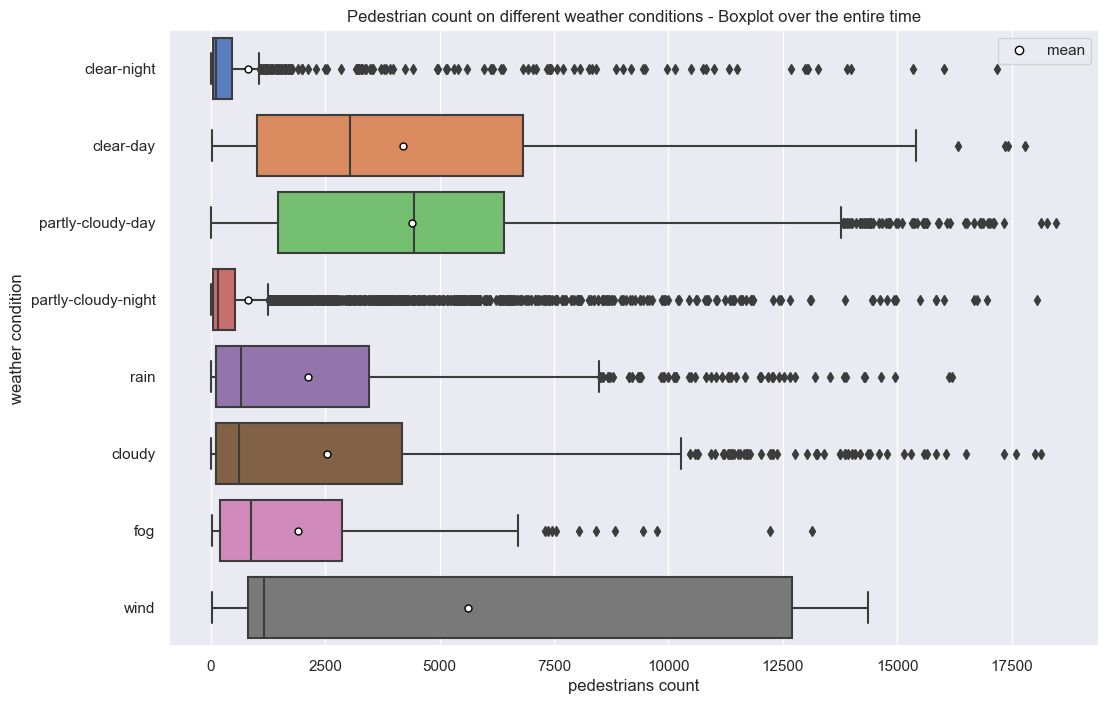

In [8]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"}) 

axs.set_title('Pedestrian count on different weather conditions - Boxplot over the entire time')

axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])    

plt.show()

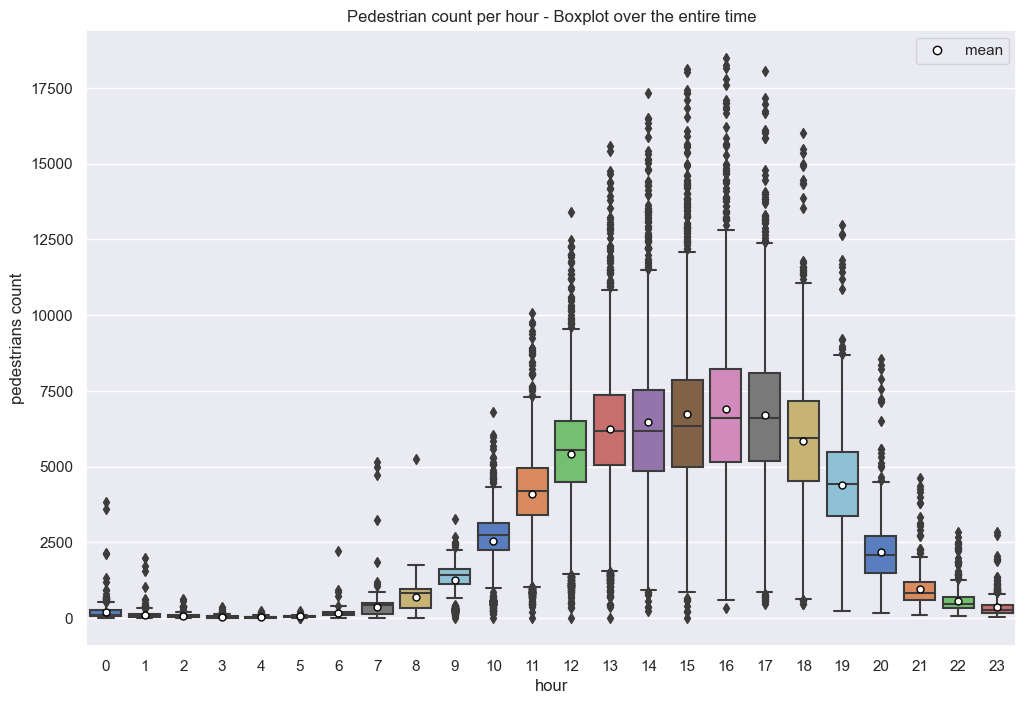

In [9]:
fig, axs = plt.subplots(figsize=(12, 8))
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per hour - Boxplot over the entire time')

axs.legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])   

plt.show()

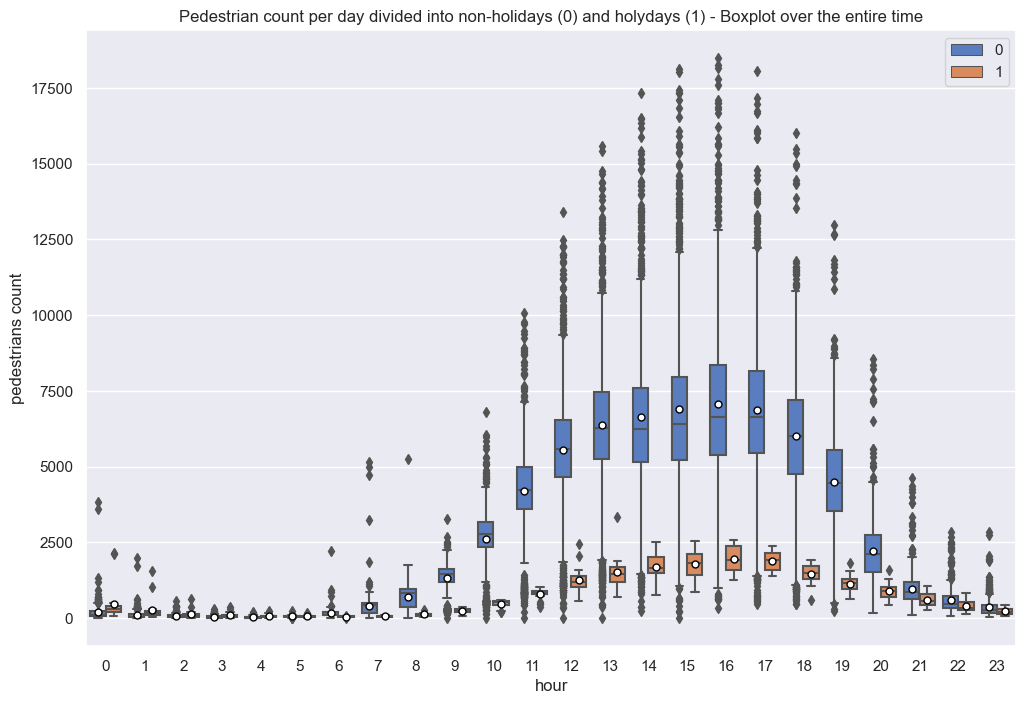

In [10]:
fig, axs = plt.subplots(figsize=(12,8))


sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per day divided into non-holidays (0) and holydays (1) - Boxplot over the entire time')

axs.legend()

plt.show()

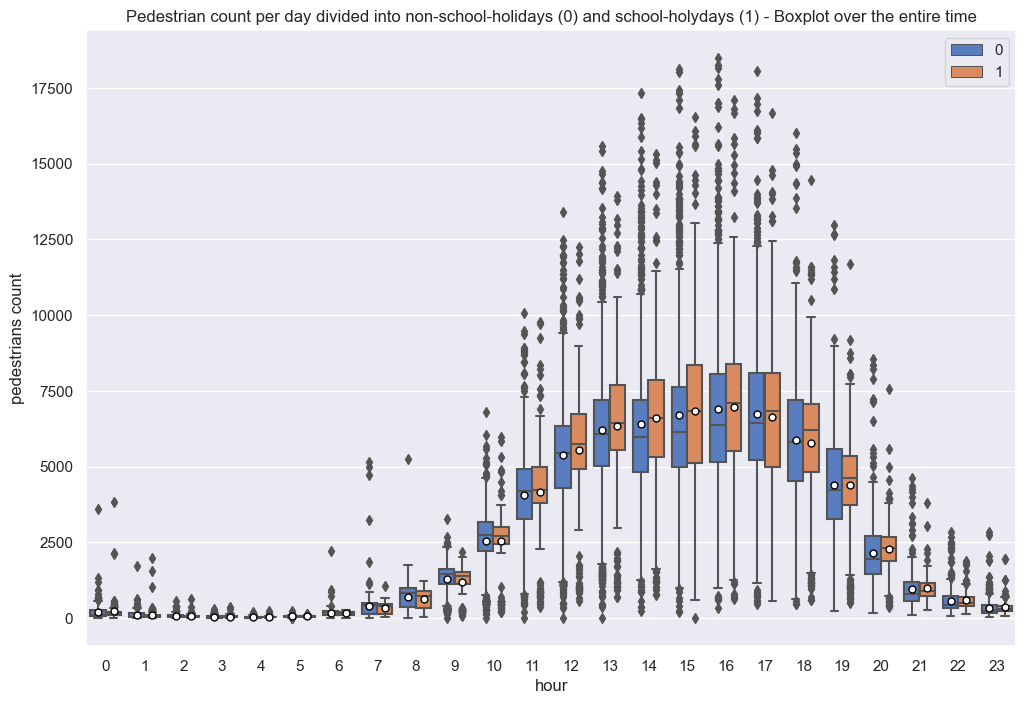

In [11]:
fig, axs = plt.subplots(figsize=(12,8))
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs.set_title('Pedestrian count per day divided into non-school-holidays (0) and school-holydays (1) - Boxplot over the entire time')

axs.legend()

plt.show()

### Baseline Model with Tensorflow

In [124]:
#Function two define two callbacks with certain parameters
def def_callbacks(stope_p = 10, reducelr_p=5, reducelr_lr=0.00001): #Use standard values when now argument is give n
    """
    stop_early patience = 10
    reduce_lr patience =5, reducelr learning rate=0.00001)
    """
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=stope_p) #Stop early stops the model fit once the Mean average error on the validation data doesn't improve after a certain amout of epochs 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, #Reduce the learning rate, by a factor of 0.2, when the Mean average error doesn't improve after a certain amout of epochs 
                              patience=reducelr_p, min_lr=reducelr_lr)
    callbacks_list = [stop_early,reduce_lr]
    return callbacks_list
    

In [125]:
#Define Baseline Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
tensorflow_base_model = keras.Sequential()

tensorflow_base_model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
tensorflow_base_model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 100 neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
tensorflow_base_model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
tensorflow_base_model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 25 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
tensorflow_base_model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

tensorflow_base_model.summary()#Display an overview of the model 


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               4700      
                                                                 
 dense_13 (Dense)            (None, 50)                5050      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 50)                2550      
                                                                 
 dense_16 (Dense)            (None, 25)                1275      
                                                                 
 dense_17 (Dense)            (None, 10)                260       
                                                                 
 dense_18 (Dense)            (None, 10)               

In [126]:
from tensorflow_addons.metrics import RSquare

#Specify the training configuration for the Neural Network
tensorflow_base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function the Optimizer minimizes --> Mean absolute error 
    metrics=["mae", RSquare()], # List of metrics to monitor
)


#Fit the model an the training data and use a validation split for ###???Cross validation????#####
tensorflow_base_history = tensorflow_base_model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #The target variable used to calculate the mean absolut error between the target variable and the predictions of the model 
    epochs=250, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data and updates the weights 
    callbacks = def_callbacks(stope_p=20), #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 20 epochs(--> def_callbacks Function)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch
)

Epoch 1/250


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 03:40:33.189763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1818.3021 - mae: 1818.3021 - r_square: 0.0999

2022-12-04 03:40:45.321835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 19s 56ms/step - loss: 1818.3021 - mae: 1818.3021 - r_square: 0.0999 - val_loss: 949.0983 - val_mae: 949.0983 - val_r_square: 0.7384 - lr: 0.0010
Epoch 2/250
269/269 [==============================] - 4s 16ms/step - loss: 828.3947 - mae: 828.3947 - r_square: 0.7842 - val_loss: 711.0712 - val_mae: 711.0712 - val_r_square: 0.8323 - lr: 0.0010
Epoch 3/250
269/269 [==============================] - 4s 15ms/step - loss: 658.0912 - mae: 658.0912 - r_square: 0.8472 - val_loss: 607.5703 - val_mae: 607.5703 - val_r_square: 0.8695 - lr: 0.0010
Epoch 4/250
269/269 [==============================] - 4s 13ms/step - loss: 556.4617 - mae: 556.4617 - r_square: 0.8823 - val_loss: 532.7245 - val_mae: 532.7245 - val_r_square: 0.8976 - lr: 0.0010
Epoch 5/250
269/269 [==============================] - 4s 15ms/step - loss: 486.9785 - mae: 486.9785 - r_square: 0.9044 - val_loss: 452.8684 - val_mae: 452.8684 - val_r_square: 0.9117 - lr: 0.0010
Epoch 6/250
269/269 [===

#### Model Evaluation

In [212]:
# Creating a dataframe to safe all results of mae and r2
comparison = pd.DataFrame(columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])

# Defining a function to fit the scenario and evaluate it
def scenario_evaluate_tensor(model, display_name, scenario, traindataX, traindatay, testdataX, testdatay, ):
    global comparison

    # Evaluate the model on the test data using `evaluate` result is the corresponding loss functin (MAE), MAE and R-squared (Metrics defined the model configuration)
    results = scenario.evaluate(Xtest, ytest)
    results_train = scenario.evaluate(Xtrain, ytrain)  

    # Compute the MAE
    mae_train = results_train[0] #First element is the loss function, Mean average error 
    mae_test = results[0] #First element is the loss function, Mean average error 
    # Comute R^2
    r2_train = results_train[2]
    r2_test = results[2]

    # Adding the calculated reults to the dataframe
    row = pd.DataFrame(data=[[model, display_name,  mae_train, mae_test, r2_train, r2_test]],
    columns=["Model", "Scenario", "MAE_train", "MAE_test", "R2_train", "R2_test"])
    comparison = pd.concat([comparison, row])
    # Merging results into dataframe and safe it as csv to add things later
    comparison = comparison.reset_index().drop(columns="index")
    comparison.to_csv("comparison_mae_r2.csv", sep=";", index=False)
    print(comparison)

In [213]:
scenario_evaluate_tensor(model="Tensorflow", display_name="Basemodel", scenario=tensorflow_base_model, traindataX=Xtrain, traindatay=ytrain, testdataX=Xtest, testdatay=ytest)

336/336 [==============================] - 2s 6ms/step - loss: 255.9613 - mae: 255.9613 - r_square: 0.9532
        Model   Scenario   MAE_train    MAE_test  R2_train   R2_test
0  Tensorflow  Basemodel  255.961304  301.013824  0.953223  0.957452


### Visualize the Model performance

2022-12-04 03:44:38.197455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 2s 6ms/step


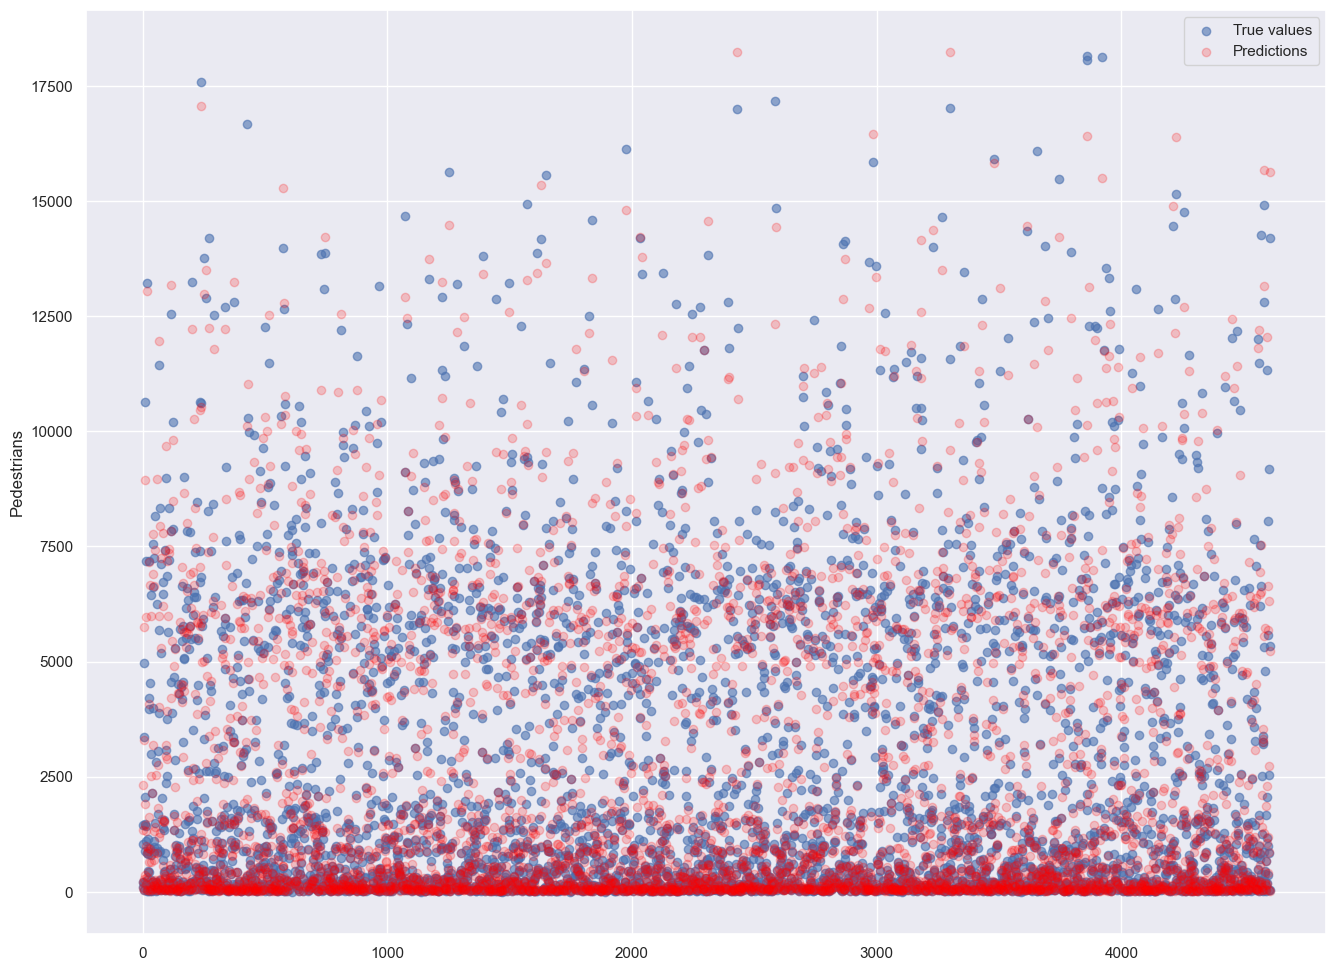

In [129]:
def plot_baseline(model, Xtest, ytest):
    # Plot the results to see the results of our base scenario
    fig, ax = plt.subplots(figsize=(16, 12))

    # Create a linspace to match the y-values
    xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

    # Plot the true values for 2 pca variables
    ax.scatter(xs, ytest, label="True values", alpha=0.6)

    # plot the predictions
    ypred = model.predict(Xtest)
    ax.scatter(xs, ypred, label="Predictions", color = "red", alpha=0.2)

    # Add labels and legend
    ax.set_ylabel("Pedestrians")
    ax.legend()

# Plot the Predictions and the Actual data for the Test set to get a first impression
plot_baseline(tensorflow_base_model, Xtest, ytest)

144/144 [==============================] - 1s 7ms/step - loss: 301.0138 - mae: 301.0138 - r_square: 0.9575


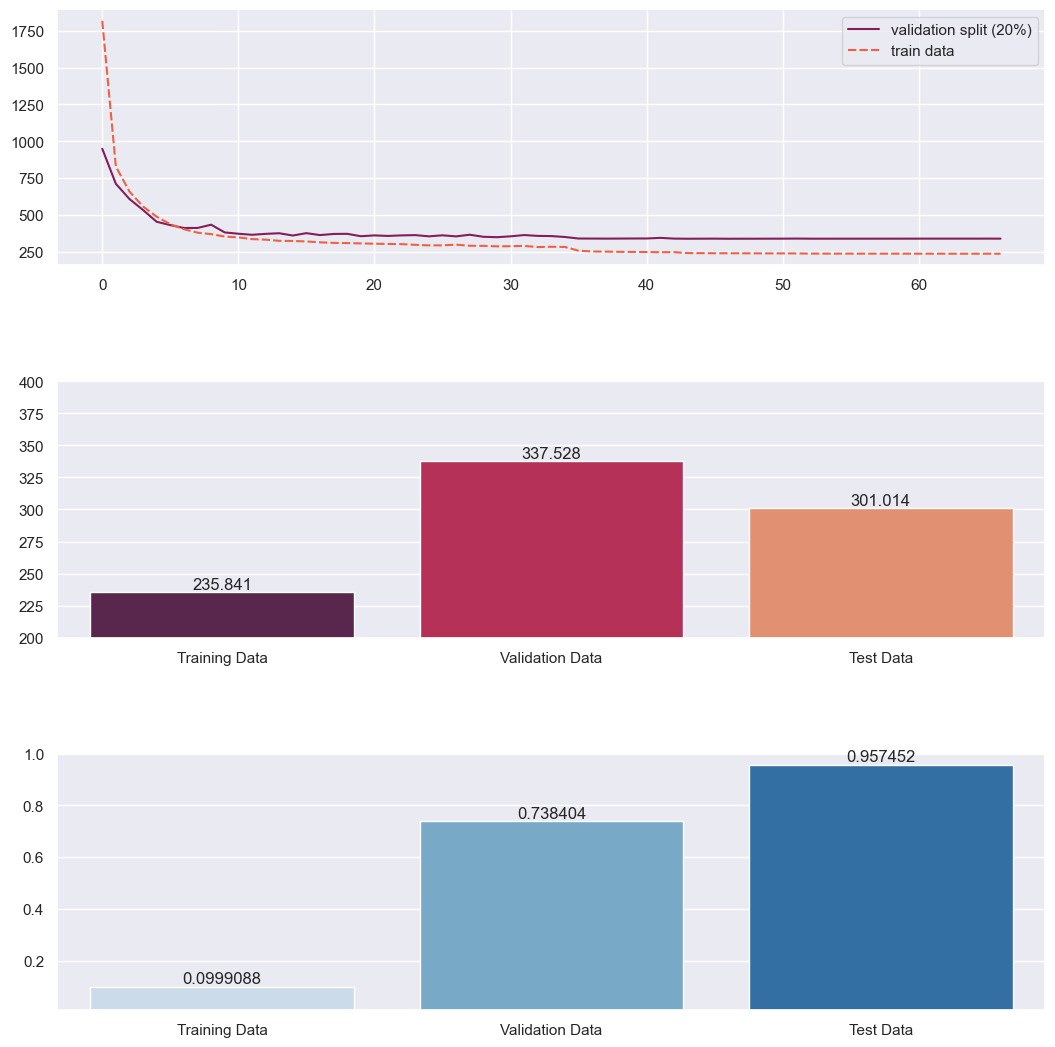

In [204]:
def tensorflow_history_vis(history, model, testdataX, testdatay, ):
        fig, axs = plt.subplots(3, figsize=(12, 12))

        fig.tight_layout(pad=5.0)
        
        train_mae_his = history.history['mae']
        val_mae_his = history.history['val_mae']

        train_mae_his = pd.DataFrame (train_mae_his, columns = ['train data'])
        val_mae_his = pd.DataFrame (val_mae_his, columns = ['validation split (20%)'])

        mae_his = pd.concat([ val_mae_his, train_mae_his], axis=1)
        sns.lineplot(palette="rocket", ax=axs[0], data=mae_his, linestyle='--')

        f_mae = tensorflow_base_history.history["mae"]
        f_val_mae = tensorflow_base_history.history["val_mae"]
        f_test_mae = tensorflow_base_model.evaluate(Xtest, ytest)

        mae_ov = {'Training Data':  [min(f_mae)],
                'Validation Data': [min(f_val_mae)],
                'Test Data': [f_test_mae[0]]
                }

        mae_ov_df = pd.DataFrame(mae_ov)

        ax = sns.barplot(mae_ov_df,  palette="rocket", errwidth=0, ax=axs[1])
        ax.bar_label(ax.containers[0])
        axs[1].set_ylim([200, 400])

        f_r = history.history["r_square"]
        f_val_r = history.history["val_r_square"]

        r_ov = {'Training Data':  [min(f_r)],
                'Validation Data': [min(f_val_r)],
                'Test Data': [f_test_mae[2]]
                }
        r_ov_df = pd.DataFrame(r_ov)

        ax = sns.barplot(r_ov_df,  palette="Blues", errwidth=0, ax=axs[2])
        ax.bar_label(ax.containers[0])
        axs[2].set_ylim([0.5,1])


tensorflow_history_vis(history=tensorflow_base_history, model=tensorflow_base_model, testdataX=Xtest, testdatay=ytest)

### Hyperparamter tuning 

#### Optimal number of layers and nodes in a wider range on 50% of the data 
##### To Analyze the different parameters

In [104]:
# Load the data and clean the Columns
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

#Create a subset with 50% of the data 
df_subset = df.sample(frac=0.5, random_state=1) 

# Define a new X with the squared feature k = 0.99, 57+46
#X_subset = np.array(df_subset[df_subset.columns[57:103]])

X_subset = df_subset[df_subset.columns[57:103]]

# Output to predict
y_subset = df_subset["pedestrians count"]

# Split the dataset into train and test sets
Xtrain_subset, Xtest_subset, ytrain_subset, ytest_subset = train_test_split(
    X_subset, y_subset, test_size=0.3, random_state=72)
## Hyperparametertuning

def tensorflow_h0_model(hp): 
 
    #Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()
    model.add(keras.layers.Flatten()) #Add an input layer 
    
# Tune the number of hidden layers and units (Nodes)
    # Number of hidden layers: 1 - 16
    for i in range(hp.Int("num_layers", 1, 16)):
        
        # Number of Nodes: 32 - 256 with stepsize of 32
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=32), #Define a Hyperparameter as a integer between 32 and 256 as different amount of Nodes 
                activation="relu") #Using relu as an activation function. Could also be defined as a Hyperparameter but in order to reduce the computing time, this will be done in the next Hyperparameter tuning
            )
        
    # if hp.Boolean("dropout"): #Define a Hyperparameter as a Boolean value to either use or not use Dropout
    #     #Will randomly "droput" (deactivate) different weights (25% of total) and train the model on the remaining. After the tuning is done all weights will be keept (so no weights are actualy not used by the final mdoel)
    #     model.add(layers.Dropout(rate=0.25)) 
    
    
    # Add output layer
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    #Here setting learning rate as a Hyperparameter would be better but it would take a lot longer since the Tuner would also have to tune the learning rate adding a huge amout of options.
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.mae,
                  metrics=["mae", RSquare()]) 
    
    return model

# Using the Hyperband tuner which selects different Hyperparameter combinations when the have promising results after a few epochs and tunes them further
tensorflow_h0_tuner = kt.Hyperband(hypermodel=tensorflow_h0_model, #Select the model that should be tuned
                     objective='val_mae', #Objective to minimize, in this case the validation split Mean average error
                     max_epochs=30, #Maximum number of epochs to train 1 model configuration 
                     hyperband_iterations=2, #the number of times to iterate over the full Hyperband algorithm
                     overwrite=True, #to be able to overwrite prior tuner entries
                     directory='kt_dir',
                     project_name='kt_Hyperband0')

#Start the Hyperparamter search on the smaller subset data (50%) 
tensorflow_h0_tuner.search(Xtrain_subset, ytrain_subset, epochs=30, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.000001, reducelr_p=3))


Trial 5 Complete [00h 00m 29s]
val_mae: 645.4417114257812

Best val_mae So Far: 578.550048828125
Total elapsed time: 00h 02m 14s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
15                |10                |num_layers
64                |64                |units_0
32                |224               |units_1
160               |224               |units_2
256               |256               |units_3
64                |64                |units_4
160               |64                |units_5
160               |32                |units_6
96                |256               |units_7
64                |128               |units_8
256               |64                |units_9
160               |32                |units_10
256               |96                |units_11
96                |160               |units_12
128               |192               |units_13
160               |32                |units_14
192               |96                |units_15


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 03:21:28.566170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - ETA: 0s - loss: 1617.0231 - mae: 1617.0231 - r_square: 0.2177

2022-12-04 03:21:45.666434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [105]:
#Safe the best Hyperparamter configurations
h0_best_hps = tensorflow_h0_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The first hyperparameter search on the smaller dataset is complete. The optimal number of layers is {h0_best_hps.get('num_layers')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
tensorflow_h0_tuner.results_summary()


The first hyperparameter search on the smaller dataset is complete. The optimal number of layers is 10.
Summary:

Results summary
Results in kt_dir/kt_Hyperband0
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 10
units_0: 64
units_1: 224
units_2: 224
units_3: 256
units_4: 64
units_5: 64
units_6: 32
units_7: 256
units_8: 128
units_9: 64
units_10: 32
units_11: 96
units_12: 160
units_13: 192
units_14: 32
units_15: 96
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 578.550048828125
Trial summary
Hyperparameters:
num_layers: 13
units_0: 64
units_1: 64
units_2: 96
units_3: 256
units_4: 128
units_5: 160
units_6: 64
units_7: 192
units_8: 256
units_9: 64
units_10: 96
units_11: 128
units_12: 256
units_13: 128
units_14: 192
units_15: 32
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 614.4173583984375
Trial summary
Hyperparameters:
num_layers: 12
units_0: 64
units_1: 160
units_2: 224
units_3: 32
units_4: 192
units_5: 1

#### Tuning Optimzer, learning rate and activation function (Hyperparameter)
##### This approach is used to reduce the computing time. A better way would be to include these as Hyperparameter in the tuning above.

In [106]:
#Find the best Optimizer, activation fucntion and learning rate for the best Model the Tuner has found

def tensorflow_h1_model(hp): 
 
#Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()

    #Tune activation function
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'selu']) #Define a Hyperparameter as a choiche (option) for different activation functions. The tuner will try these to find the best possible for the baseline model 

    model.add(keras.layers.Flatten()) #Add a Input layer and use flatten to get a 1 dimensional input
    model.add(layers.Dense(160, activation=hp_activation))  
    model.add(layers.Dense(32, activation=hp_activation)) 
    model.add(layers.Dense(160, activation=hp_activation)) 
    model.add(layers.Dense(256, activation=hp_activation))
    model.add(layers.Dense(224, activation=hp_activation)) 
    model.add(layers.Dense(1, activation=hp_activation))  #Add an output layer with activation function relu  

    #Tune learning rate 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])  # Define a Hyperparameter as a choice to tune learning rate with the values 0.01, 0.001, 0.0001, 0.00001

    #Create a dictionary to hold the different optimization functions 
    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice( #Define a Hyperparameter as a choice to tune the optimizer 
        'optimizer', values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"] #Options the tuner will try, that correspond to the optimizer dictionary keys 
        )


    model.compile(optimizer=optimizers_dict[hp_optimizers], #Complie the model and use the optimizer choice as input for the optimizer 
                  loss=keras.losses.mae, #Loss function is Mean average error 
                  metrics=["mae", RSquare()])
    
    return model

In [107]:
#Easy tuner because we only have 5 different Optimizer options, 3 learning rate optimizations and 3 activation functions, 
# so randomly selecting is okay because no matter what we will try every combination of the 40
tensorflow_h1_tuner = kt.RandomSearch(hypermodel = tensorflow_h1_model, #The model the Randomsearch tuner will tune 
                       objective = 'val_mae', #Objetive the tuner will try to minimize 
                       max_trials =45 , #The total number of trails to test at most (to try every combination it has to be at least 40 (5*4*2))
                       directory = 'kt_dir', #create a dictionary to store the tries and metrics 
                       overwrite=True, #To be able to overwrite prior tuner entries
                       project_name = 'kt_RandomSearch')

In [108]:
#Initiate the tuner with the Train data
#Tune for 30 epochs with a validation split of 20% and a possible minimum learning rate of 0.000001 for the Reduce learning rate callback function
tensorflow_h1_tuner.search(Xtrain, ytrain, epochs=20, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.00001)) 

Trial 9 Complete [00h 01m 01s]
val_mae: 373.5516662597656

Best val_mae So Far: 342.70391845703125
Total elapsed time: 00h 10m 17s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation
0.01              |0.01              |learning_rate
Adadelta          |RMSprop           |optimizer

Epoch 1/10


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 03:32:20.297752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 12/269 [>.............................] - ETA: 56s - loss: 2774.9712 - mae: 2774.9712 - r_square: -0.6665

KeyboardInterrupt: 

In [136]:
#Create a new Model with the Hyperparameters found by the tuner
h1_best_hps = tensorflow_h1_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The second hyperparameter search is complete. The best optimizer is {h1_best_hps.get('optimizer')}, the best activation function is 
{h1_best_hps.get("activation")} and the optimal learning rate for the optimizer is {h1_best_hps.get('learning_rate')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
tensorflow_h1_tuner.results_summary() 

#Hypertuned Model 
tensorflow_hypertuned_model = tensorflow_h1_tuner.hypermodel.build(h1_best_hps)
#Create a new History for the model to compare it with the Baseline Histroy 
tensorflow_hypertuned_history = tensorflow_hypertuned_model.fit(Xtrain, ytrain, epochs=250, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


The second hyperparameter search is complete. The best optimizer is RMSprop, the best activation function is 
relu and the optimal learning rate for the optimizer is 0.01.
Summary:

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: RMSprop
Score: 342.70391845703125
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adam
Score: 373.5516662597656
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.001
optimizer: SGD
Score: 418.3036193847656
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
optimizer: SGD
Score: 427.6551208496094
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
optimizer: RMSprop
Score: 775.4552001953125
Trial summary
Hyperparameters:
activation: selu
learning_rate: 0.001
optimizer: Adagrad
Score: 1030.7276611328125
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
optimi

/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-04 03:47:22.295985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1046.7156 - mae: 1046.7156 - r_square: 0.6421

2022-12-04 03:47:37.893784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 23s 68ms/step - loss: 1046.7156 - mae: 1046.7156 - r_square: 0.6421 - val_loss: 1230.6876 - val_mae: 1230.6876 - val_r_square: 0.5774 - lr: 0.0100
Epoch 2/250
269/269 [==============================] - 5s 18ms/step - loss: 687.8546 - mae: 687.8546 - r_square: 0.8265 - val_loss: 470.5106 - val_mae: 470.5106 - val_r_square: 0.9057 - lr: 0.0100
Epoch 3/250
269/269 [==============================] - 4s 17ms/step - loss: 584.4256 - mae: 584.4256 - r_square: 0.8678 - val_loss: 1053.8679 - val_mae: 1053.8679 - val_r_square: 0.6804 - lr: 0.0100
Epoch 4/250
269/269 [==============================] - 5s 18ms/step - loss: 542.3743 - mae: 542.3743 - r_square: 0.8822 - val_loss: 807.2549 - val_mae: 807.2549 - val_r_square: 0.7891 - lr: 0.0100
Epoch 5/250
269/269 [==============================] - 5s 19ms/step - loss: 490.7123 - mae: 490.7123 - r_square: 0.9042 - val_loss: 396.8124 - val_mae: 396.8124 - val_r_square: 0.9254 - lr: 0.0100
Epoch 6/250
269/269 

In [214]:
# Evaluate model on test set using the above created function to save the results in the omparisson dataframe
scenario_evaluate_tensor(model="Tensorflow", display_name="Hypertuned model", scenario=tensorflow_hypertuned_model, traindataX=Xtrain, traindatay=ytrain, testdataX=Xtest, testdatay=ytest)

336/336 [==============================] - 3s 9ms/step - loss: 240.7280 - mae: 240.7280 - r_square: 0.9579
        Model          Scenario   MAE_train    MAE_test  R2_train   R2_test
0  Tensorflow         Basemodel  255.961304  301.013824  0.953223  0.957452
1  Tensorflow  Hypertuned model  240.728043  295.487549  0.957883  0.955346


### Viusalize the Hypertuned Model 

2022-12-04 03:36:13.178277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 5ms/step


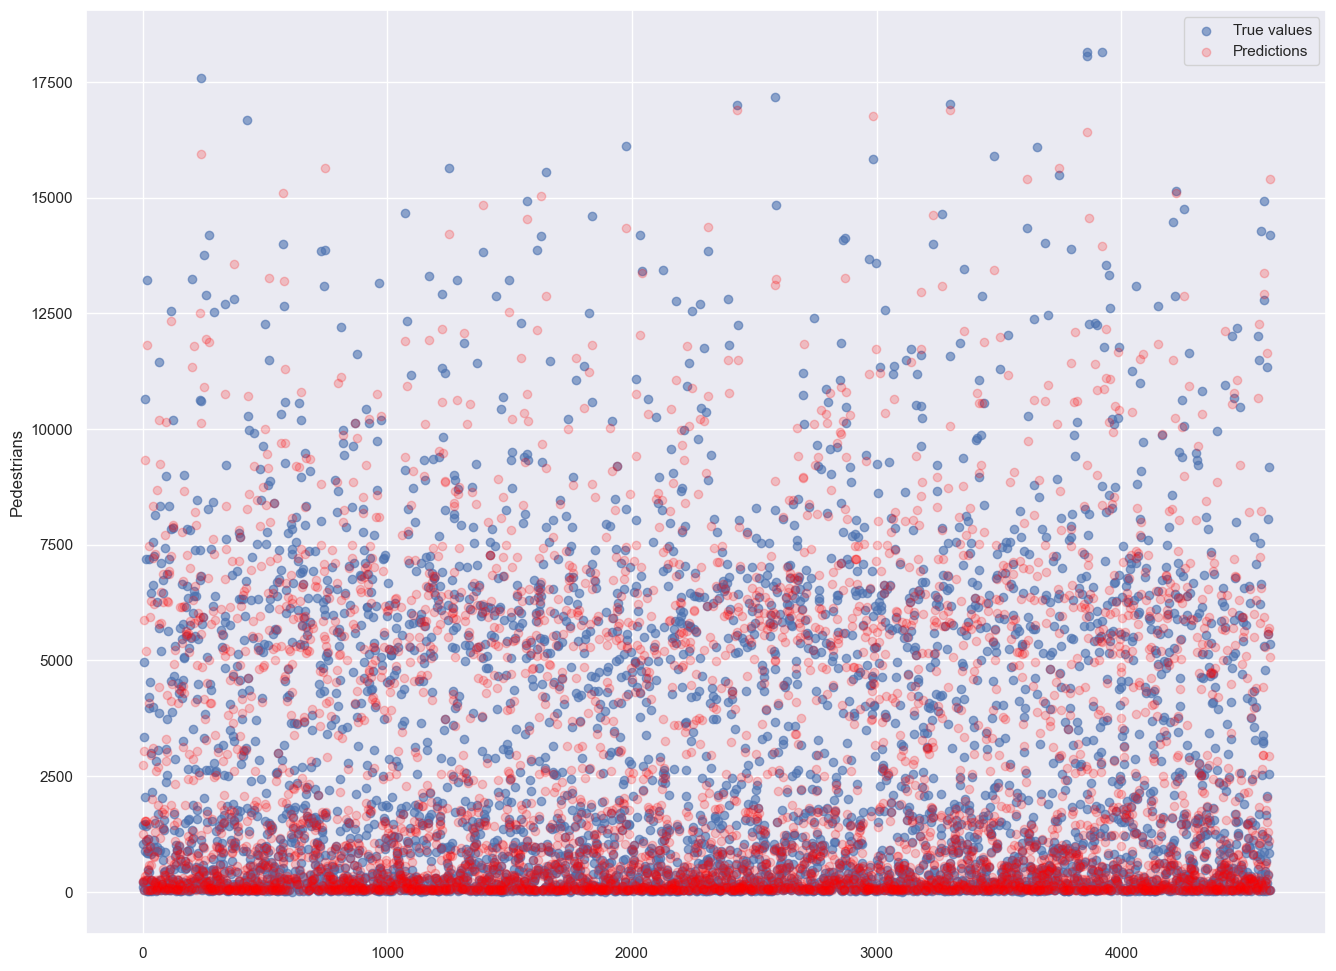

In [120]:
#Visualize the results predictions vs actual values
plot_baseline(tensorflow_hypertuned_history, Xtest, ytest)

144/144 [==============================] - 1s 6ms/step - loss: 301.0138 - mae: 301.0138 - r_square: 0.9575


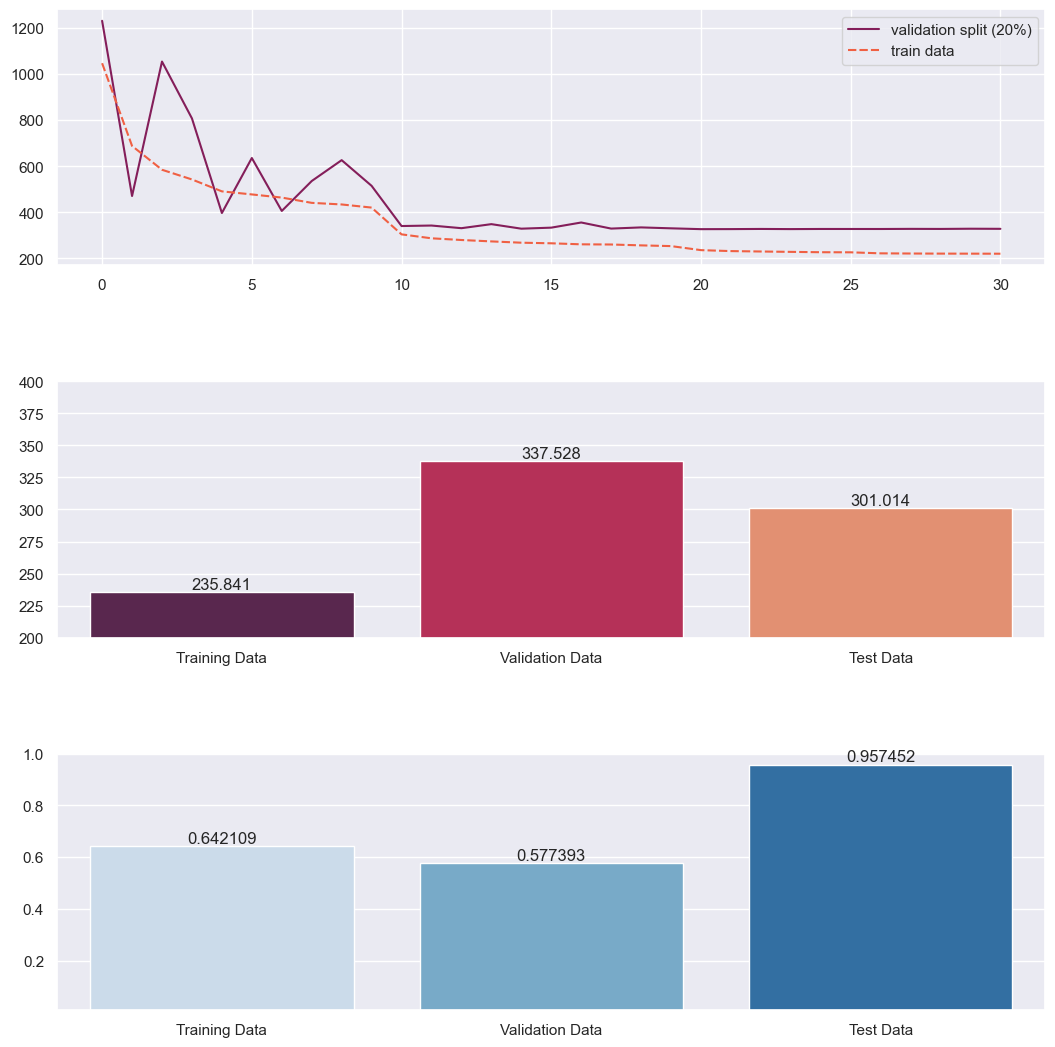

In [205]:
#Plot the MAE on the training data against the validation split of the Training data over time, aswell as the MAE and R-squared on the Test data, validation data and Test Data
tensorflow_history_vis(history=tensorflow_hypertuned_history, model=tensorflow_hypertuned_model, testdataX=Xtest, testdatay=ytest)

#### Visualize the predictions in comparisson with actual values 

#### This is with all data

In [62]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts = []
for uper in split:
    part = df.loc[(df["pedestrians count"] >= lower) & (df["pedestrians count"] < uper)]
    lower = uper
    seperate_parts.append(part)

#### This is with all data

In [63]:
Xtest_new = Xtest.reset_index(drop=True)
ytest_new = ytest.reset_index(drop=True)

In [64]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts_y = []
seperate_parts_x = []

for uper in split:
    y_part = ytest_new[(ytest_new >= lower) & (ytest_new < uper)]
    index_for_x = y_part.index[0:len(y_part)]
    x_part = Xtest_new.loc[index_for_x,]
    lower = uper
    seperate_parts_y.append(y_part)
    seperate_parts_x.append(x_part)

In [65]:
x_graph = np.linspace(0, len(y_graph), num=len(y_graph))
np.count_nonzero(~np.isnan(x_graph))
x_graph.max()

NameError: name 'y_graph' is not defined

1/1 [==============================] - 0s 167ms/step


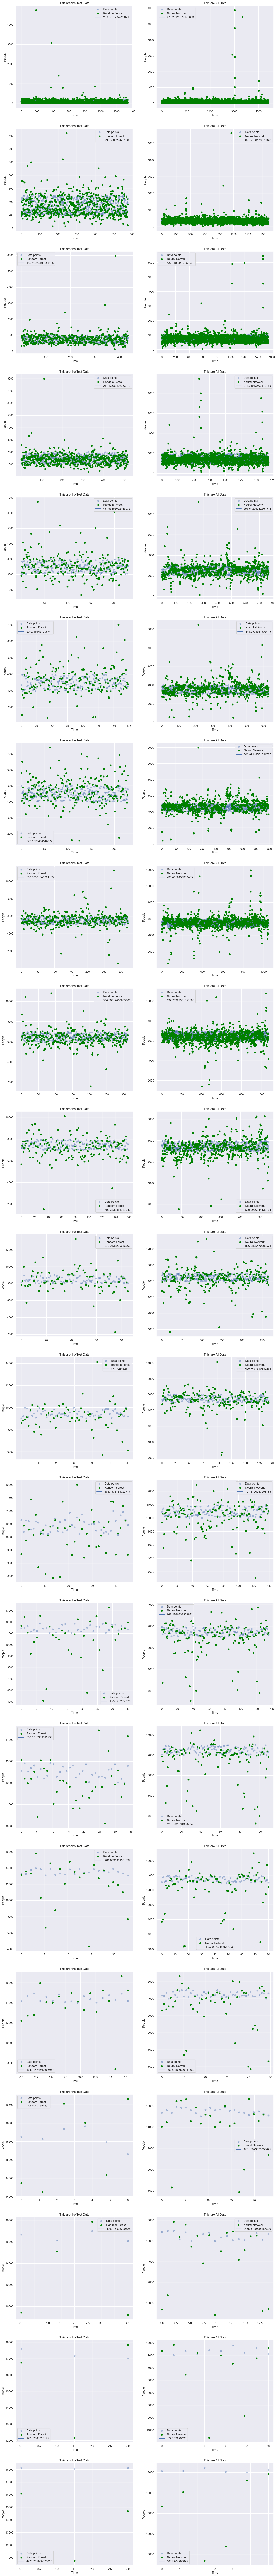

In [67]:
from sklearn.metrics import mean_absolute_error
# Set up the canvas
fig, axs = plt.subplots(len(seperate_parts),2,figsize=(18, 180))
# Make a scatterplot with temperature on the x-axis and number of rentals on the y axis

#################################################
#THIS IS FOR TEST ONLY
#################################################
for i in range(len(seperate_parts_y)):
    X_calc = seperate_parts_x[i] #[seperate_parts_x[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts_y[i]#["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = h1_model.predict(X_calc)

    axs[i][0].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][0].scatter(x_graph, y_pred_graph, label="Random Forest", color="green", lw=1)
    axs[i][0].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][0].legend()
    axs[i][0].set_xlabel("Time")
    axs[i][0].set_ylabel("People")
    axs[i][0].set_title("This are the Test Data")

#################################################
# THIS IS FOR ALL
#################################################
for i in range(len(seperate_parts)):
    X_calc = seperate_parts[i][seperate_parts[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts[i]["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = h1_model.predict(X_calc)

    axs[i][1].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][1].scatter(x_graph, y_pred_graph, label="Neural Network", color="green", lw=1)
    axs[i][1].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][1].legend()
    axs[i][1].set_xlabel("Time")
    axs[i][1].set_ylabel("People")
    axs[i][1].set_title("This are All Data")

#### Visualize all Models

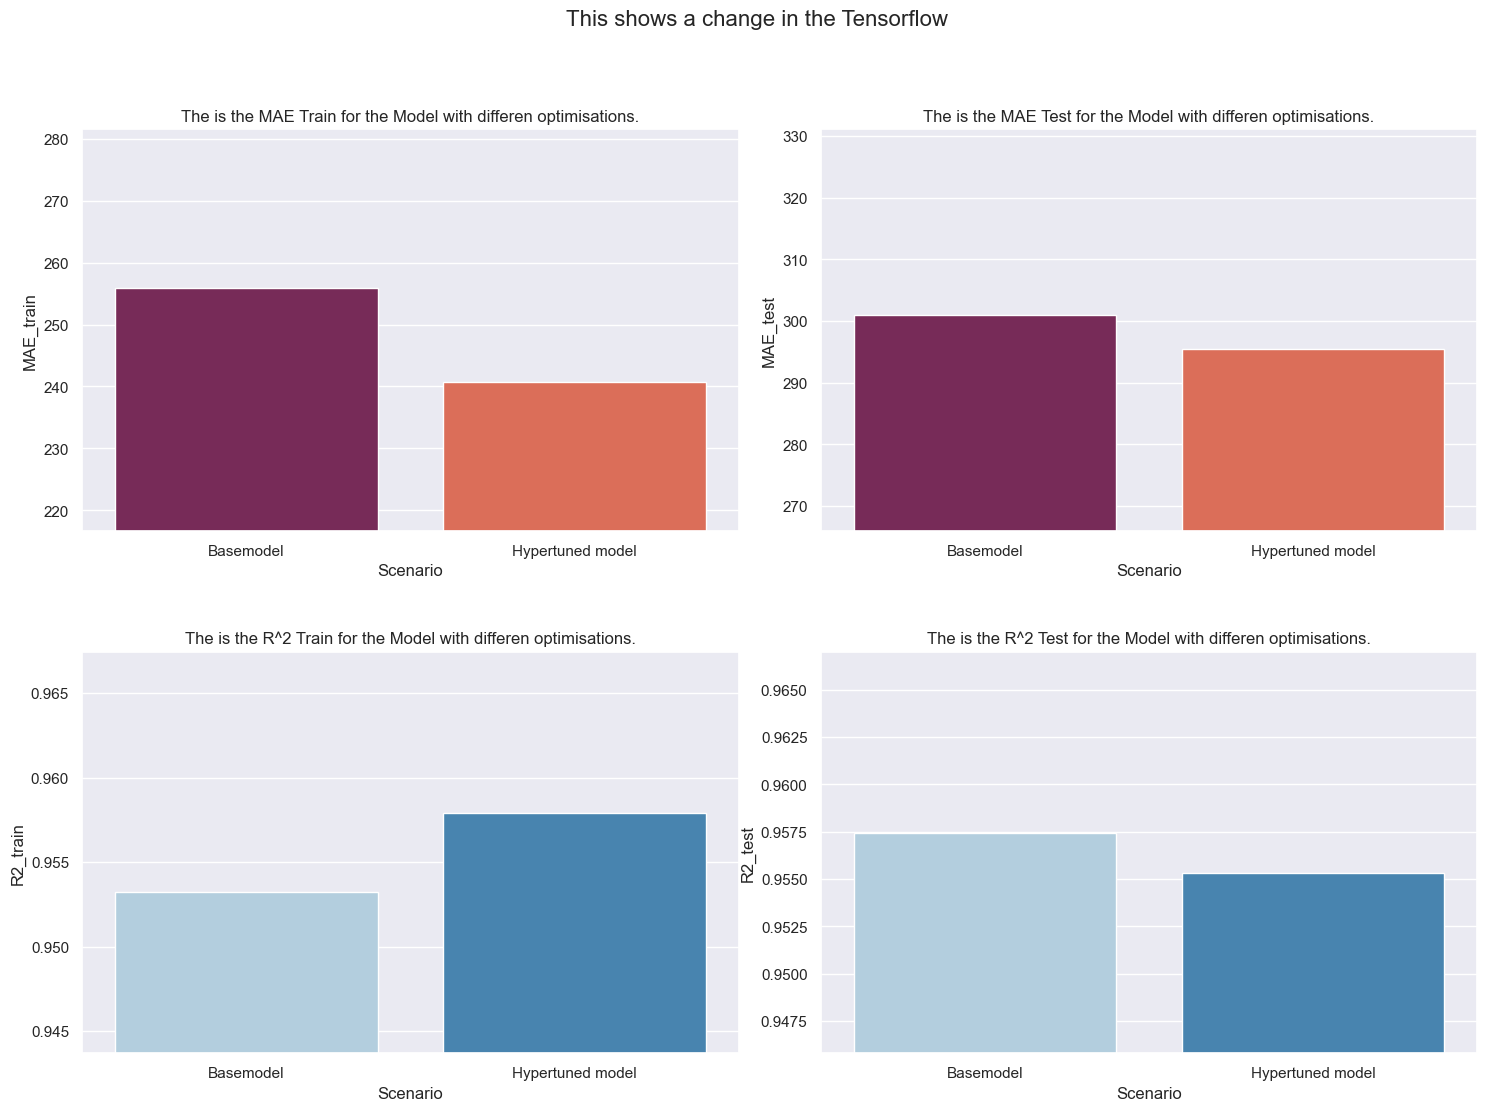

In [215]:
#Define a Function to plot the comparison of the models
def plot_bars_comp(model, dataframe):
    # Define the dimensions and model of the plot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    plot_data = dataframe[dataframe["Model"] == model]

    # Get the MAE train bars
    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_train", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim((plot_data["MAE_train"].min())*0.9, (plot_data["MAE_train"].max())*1.1)
    mae_train_axes.set_title(f"The is the MAE Train for the Model with differen optimisations.")

    # Get the MAE test bars
    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="Scenario", y="MAE_test", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim((plot_data["MAE_test"].min())*0.9, (plot_data["MAE_test"].max())*1.1)
    mae_test_axes.set_title(f"The is the MAE Test for the Model with differen optimisations.")


    # Get the r2 train bars
    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="Scenario", y="R2_train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim((plot_data["R2_train"].min())*0.99, (plot_data["R2_train"].max())*1.01)
    r2_train_axes.set_title(f"The is the R^2 Train for the Model with differen optimisations.")


    # Get the r2 test bars
    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="Scenario", y="R2_test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim((plot_data["R2_test"].min())*0.99, (plot_data["R2_test"].max())*1.01)
    r2_test_axes.set_title(f"The is the R^2 Test for the Model with differen optimisations.")

    fig.subplots_adjust(hspace=0.3, wspace=0.125)
    # Set a Titel
    fig.suptitle(f"This shows a change in the {model}", fontsize=16)
    fig.savefig(f"plots/{model} comparison.png")


plot_bars_comp("Tensorflow", comparison)
